In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

import rocks
rocks.set_log_level("error")
import time as t


from astropy.time import Time
import requests
import io

import astropy.units as u
from astropy.coordinates import SkyCoord
# from astropy.coordinates import angular_separation

from scipy.signal import argrelextrema

import ssptools


import fink_utils.sso.spins as finkus


# Get ZTF fit

In [4]:
# Local Configuration
data_fink = '../'


In [5]:
# ZTF filters 1: g, 2: r
filters = {'1': 'g', '2': 'r'}

S_color = {'g': -0.3928, 'r':0.2913}
sun_color = {'g': -0.3044, 'r':0.1903}

color_C = -(sun_color['g']-sun_color['r'])
color_S = -(S_color['g']-S_color['r'])

# From apparent magnitude to unit distance
def dist_reduction( d_obs, d_sun):
    return 5*np.log10( d_obs * d_sun )

V_minus_g = -0.32
V_minus_r = 0.13
# V_minus_r_test = 0.36       


In [68]:
data = pd.read_parquet(f'{data_fink}data/ztf/sso_ZTF.parquet')

In [7]:
# import sys
# sys.path.append('/home/bcarry/Documents/softs/ocapy/gfx/')
# import figure_setup as fs

# Check results for individual SSOs

In [8]:
target = '1465'

In [9]:
# Get ZTF observations
r = requests.post(
  'https://fink-portal.org/api/v1/sso',
  json={
    'n_or_d': target,
    'withEphem': True,
    'output-format': 'json'
  }
)

# Format output in a DataFrame
ztf = pd.read_json(io.BytesIO(r.content))
len(ztf)

257

In [11]:
ztf.columns

Index(['index', 'Date', 'LAST', 'HA', 'Az', 'H', 'Dobs', 'Dhelio', 'VMag',
       'SDSS:g', 'SDSS:r', 'Phase', 'Elong.', 'AM', 'dRAcosDEC', 'dDEC', 'RV',
       'RA', 'Dec', 'Longitude', 'Latitude', 'd:DR3Name', 'd:Plx',
       'd:anomaly_score', 'd:cdsxmatch', 'd:e_Plx', 'd:gcvs',
       'd:mangrove_2MASS_name', 'd:mangrove_HyperLEDA_name',
       'd:mangrove_ang_dist', 'd:mangrove_lum_dist', 'd:mulens',
       'd:rf_kn_vs_nonkn', 'd:rf_snia_vs_nonia', 'd:roid', 'd:snn_sn_vs_all',
       'd:snn_snia_vs_nonia', 'd:t2_AGN', 'd:t2_EB', 'd:t2_KN', 'd:t2_M-dwarf',
       'd:t2_Mira', 'd:t2_RRL', 'd:t2_SLSN-I', 'd:t2_SNII', 'd:t2_SNIa',
       'd:t2_SNIa-91bg', 'd:t2_SNIax', 'd:t2_SNIbc', 'd:t2_TDE',
       'd:t2_mu-Lens-Single', 'd:vsx', 'd:x3hsp', 'd:x4lac', 'i:candid',
       'i:chipsf', 'i:classtar', 'i:dec', 'i:diffmaglim', 'i:distnr',
       'i:distpsnr1', 'i:drb', 'i:fid', 'i:field', 'i:isdiffpos', 'i:jd',
       'i:jdendhist', 'i:jdstarthist', 'i:maggaia', 'i:magnr', 'i:magpsf',
   

In [12]:
# Compute Ephemerides
jd_min = ztf['Date'].min()
jd_max = ztf['Date'].max()
step = 2
nbd = (jd_max-jd_min) / step

eph = ssptools.ephemcc( target, ep=jd_min, nbd=nbd, step=f'{step}d')

# obs = ssptools.ephemcc( target, ep=ztf.Date)

In [13]:
ztf.columns

Index(['index', 'Date', 'LAST', 'HA', 'Az', 'H', 'Dobs', 'Dhelio', 'VMag',
       'SDSS:g', 'SDSS:r', 'Phase', 'Elong.', 'AM', 'dRAcosDEC', 'dDEC', 'RV',
       'RA', 'Dec', 'Longitude', 'Latitude', 'd:DR3Name', 'd:Plx',
       'd:anomaly_score', 'd:cdsxmatch', 'd:e_Plx', 'd:gcvs',
       'd:mangrove_2MASS_name', 'd:mangrove_HyperLEDA_name',
       'd:mangrove_ang_dist', 'd:mangrove_lum_dist', 'd:mulens',
       'd:rf_kn_vs_nonkn', 'd:rf_snia_vs_nonia', 'd:roid', 'd:snn_sn_vs_all',
       'd:snn_snia_vs_nonia', 'd:t2_AGN', 'd:t2_EB', 'd:t2_KN', 'd:t2_M-dwarf',
       'd:t2_Mira', 'd:t2_RRL', 'd:t2_SLSN-I', 'd:t2_SNII', 'd:t2_SNIa',
       'd:t2_SNIa-91bg', 'd:t2_SNIax', 'd:t2_SNIbc', 'd:t2_TDE',
       'd:t2_mu-Lens-Single', 'd:vsx', 'd:x3hsp', 'd:x4lac', 'i:candid',
       'i:chipsf', 'i:classtar', 'i:dec', 'i:diffmaglim', 'i:distnr',
       'i:distpsnr1', 'i:drb', 'i:fid', 'i:field', 'i:isdiffpos', 'i:jd',
       'i:jdendhist', 'i:jdstarthist', 'i:maggaia', 'i:magnr', 'i:magpsf',
   

In [16]:
# Compute Lambda
coords = SkyCoord( ztf['i:ra'], ztf['i:dec'], unit=(u.hourangle, u.deg) )

ra0 = data.loc[data.ssnamenr==target, 'sHG1G2_RA0'].values[0]
dec0 = data.loc[data.ssnamenr==target, 'sHG1G2_DEC0'].values[0]

ra = np.radians(coords.ra.deg)
dec = np.radians(coords.dec.deg)
cos_lambda = np.sin(dec)*np.sin(dec0) + np.cos(dec)*np.cos(dec0)*np.cos(ra-ra0)
np.degrees(np.arccos(  np.quantile(cos_lambda, [0,0.25,0.5,0.75,1])  ))
np.quantile(cos_lambda, [0,0.25,0.5,0.75,1]) 

array([-0.56352268, -0.26202557, -0.00240602,  0.3296189 ,  0.70718136])

In [17]:
# Compute Lambda
coords = SkyCoord( eph.RA, eph.DEC, unit=(u.hourangle, u.deg) )

ra0 = data.loc[data.ssnamenr==target, 'sHG1G2_RA0'].values[0]
dec0 = data.loc[data.ssnamenr==target, 'sHG1G2_DEC0'].values[0]

ra = np.radians(coords.ra.deg)
dec = np.radians(coords.dec.deg)
cos_lambda = np.sin(dec)*np.sin(dec0) + np.cos(dec)*np.cos(dec0)*np.cos(ra-ra0)

In [18]:
np.degrees(np.arccos(  np.quantile(cos_lambda, [0,1])  ))

array([121.01241873,  60.9236586 ])

In [69]:
ztf.columns

Index(['index', 'Date', 'LAST', 'HA', 'Az', 'H', 'Dobs', 'Dhelio', 'VMag',
       'SDSS:g', 'SDSS:r', 'Phase', 'Elong.', 'AM', 'dRAcosDEC', 'dDEC', 'RV',
       'RA', 'Dec', 'Longitude', 'Latitude', 'd:DR3Name', 'd:Plx',
       'd:anomaly_score', 'd:cdsxmatch', 'd:e_Plx', 'd:gcvs',
       'd:mangrove_2MASS_name', 'd:mangrove_HyperLEDA_name',
       'd:mangrove_ang_dist', 'd:mangrove_lum_dist', 'd:mulens',
       'd:rf_kn_vs_nonkn', 'd:rf_snia_vs_nonia', 'd:roid', 'd:snn_sn_vs_all',
       'd:snn_snia_vs_nonia', 'd:t2_AGN', 'd:t2_EB', 'd:t2_KN', 'd:t2_M-dwarf',
       'd:t2_Mira', 'd:t2_RRL', 'd:t2_SLSN-I', 'd:t2_SNII', 'd:t2_SNIa',
       'd:t2_SNIa-91bg', 'd:t2_SNIax', 'd:t2_SNIbc', 'd:t2_TDE',
       'd:t2_mu-Lens-Single', 'd:vsx', 'd:x3hsp', 'd:x4lac', 'i:candid',
       'i:chipsf', 'i:classtar', 'i:dec', 'i:diffmaglim', 'i:distnr',
       'i:distpsnr1', 'i:drb', 'i:fid', 'i:field', 'i:isdiffpos', 'i:jd',
       'i:jdendhist', 'i:jdstarthist', 'i:maggaia', 'i:magnr', 'i:magpsf',
   

In [20]:
hg_model = {'name':'HG', 
           'H': data.loc[data.ssnamenr==target, 'HG_H_r'].values[0], 
           'G': data.loc[data.ssnamenr==target, 'HG_G_r'].values[0]
           }
hg1g2_model = {'name':'HG1G2', 
    'H': data.loc[data.ssnamenr==target, 'HG1G2_H_r'].values[0],
    'G1': data.loc[data.ssnamenr==target, 'HG1G2_G1_r'].values[0],
    'G2': data.loc[data.ssnamenr==target, 'HG1G2_G2_r'].values[0]
               }
hg_model
hg1g2_model

{'name': 'HG1G2',
 'H': 11.14454460144043,
 'G1': 0.5864540338516235,
 'G2': 0.0034235597122460604}

In [21]:
hg_model['name']

'HG'

In [70]:
data.columns

Index(['ssnamenr', 'nmeasurements', 'ndays', 'params', 'number', 'name',
       'HG_H_g', 'HG_dH_g', 'HG_G_g', 'HG_dG_g', 'HG_rms_g', 'HG_H_r',
       'HG_dH_r', 'HG_G_r', 'HG_dG_r', 'HG_rms_r', 'minphase', 'maxphase',
       'n_days', 'n_obs', 'HG_rms', 'HG_chi2red', 'HG1G2_status_x',
       'HG1G2_fit_x', 'HG1G2_H_g', 'HG1G2_dH_g', 'HG1G2_G1_g', 'HG1G2_dG1_g',
       'HG1G2_G2_g', 'HG1G2_dG2_g', 'HG1G2_rms_g', 'HG1G2_H_r', 'HG1G2_dH_r',
       'HG1G2_G1_r', 'HG1G2_dG1_r', 'HG1G2_G2_r', 'HG1G2_dG2_r', 'HG1G2_rms_r',
       'HG1G2_rms', 'HG1G2_chi2red', 'HG1G2_status_y', 'HG1G2_fit_y',
       'sHG1G2_H_g', 'sHG1G2_dH_g', 'sHG1G2_G1_g', 'sHG1G2_dG1_g',
       'sHG1G2_G2_g', 'sHG1G2_dG2_g', 'sHG1G2_rms_g', 'sHG1G2_H_r',
       'sHG1G2_dH_r', 'sHG1G2_G1_r', 'sHG1G2_dG1_r', 'sHG1G2_G2_r',
       'sHG1G2_dG2_r', 'sHG1G2_rms_r', 'sHG1G2_RA0', 'sHG1G2_dRA0',
       'sHG1G2_DEC0', 'sHG1G2_dDEC0', 'sHG1G2_R', 'sHG1G2_dR', 'sHG1G2_rms',
       'sHG1G2_chi2red', 'sHG1G2_status', 'sHG1G2_fit', 'sH

In [79]:
from abc import ABC, abstractmethod

class Model(ABC):

    # Local Configuration
    data_fink = '../'
    # ZTF Colors and Colors
    colors = ['#15284F', '#F5622E']
    __dict_band = {"g": 1, "r": 2}

    def __init__(self, band: str, target: str) -> None:

        self.data = pd.read_parquet(f'{Model.data_fink}data/ztf/sso_ZTF.parquet')
        self.target = target
        self.reset_filter(band)
        self.reset_target(self.target)
    
    def reset_target(self, target):
        # Get ZTF observations
        r = requests.post(
        'https://fink-portal.org/api/v1/sso',
        json={
            'n_or_d': target,
            'withEphem': True,
            'output-format': 'json'
        }
        )

        # Format output in a DataFrame
        self.ztf = pd.read_json(io.BytesIO(r.content))

        # Compute Ephemerides
        jd_min = self.ztf['Date'].min()
        jd_max = self.ztf['Date'].max()
        self.step = 2
        nbd = (jd_max-jd_min) / self.step

        self.eph = ssptools.ephemcc( target, ep=jd_min, nbd=nbd, step=f'{self.step}d')

    def reset_filter(self, band):
        self.filter = band
        self.int_filter = Model.__dict_band[self.filter]

    # From apparent magnitude to unit distance
    def dist_reduction(d_obs, d_sun):
        return 5*np.log10( d_obs * d_sun )
    
    @abstractmethod
    def mag_model(self):
        pass

    def mag_dist(self, x_model, x_red):
        return self.mag_model(x_model) + Model.dist_reduction( *x_red )

    def mag_dist_eph(self):
        return self.mag_dist(
            np.radians(self.eph['Phase']),
            (self.eph['Dobs'], self.eph['Dhelio'])
        )

    def mag_dist_ztf(self):
        cond = self.ztf['i:fid'] == self.int_filter
        return self.mag_dist(
            np.radians(self.ztf.loc[cond, 'Phase']),
            (self.ztf.loc[cond, 'Dobs'], self.ztf.loc[cond, 'Dhelio'])
        )
    
    def residuals(self):
        cond = self.ztf['i:fid'] == self.int_filter
        return self.ztf.loc[cond,'i:magpsf'] - self.mag_dist_ztf()

In [80]:
class HG(Model):

    def get_data_model(self):
        H = self.data.loc[self.data.ssnamenr==self.target, 'HG_H_{}'.format(self.filter)].values[0]
        G = self.data.loc[self.data.ssnamenr==self.target, 'HG_G_{}'.format(self.filter)].values[0]
        return H, G

    def mag_model(self, x):
        H, G = self.get_data_model()
        return finkus.func_hg(x, H, G)

In [81]:
class HG1G2(Model):

    def get_data_model(self):
        H = self.data.loc[self.data.ssnamenr==self.target, 'HG1G2_H_{}'.format(self.filter)].values[0]
        G1 = self.data.loc[self.data.ssnamenr==self.target, 'HG1G2_G1_{}'.format(self.filter)].values[0]
        G2 = self.data.loc[self.data.ssnamenr==self.target, 'HG1G2_G2_{}'.format(self.filter)].values[0]
        return H, G1, G2

    def mag_model(self, x):
        H, G1, G2 = self.get_data_model()
        return finkus.func_hg1g2(x, H, G1, G2)

In [82]:
class sHG1G2(Model):

    def get_data_model(self):
        H = self.data.loc[self.data.ssnamenr==self.target, f'sHG1G2_H_{self.filter}'].values[0]
        G1 = self.data.loc[self.data.ssnamenr==self.target, f'sHG1G2_G1_{self.filter}'].values[0]
        G2 = self.data.loc[self.data.ssnamenr==self.target, f'sHG1G2_G2_{self.filter}'].values[0]
        sRA = self.data.loc[self.data.ssnamenr==self.target, 'sHG1G2_RA0'].values[0]
        sDEC = self.data.loc[self.data.ssnamenr==self.target, 'sHG1G2_DEC0'].values[0]
        R = self.data.loc[self.data.ssnamenr==self.target, 'sHG1G2_R'].values[0]
        return H, G1, G2, sRA, sDEC, R

    def pha_eph(self):
        spin_coord = SkyCoord( self.eph.RA, self.eph.DEC, unit=(u.hourangle, u.deg) )
        pha = np.transpose([[i, j, k] for i, j, k in
                            zip(np.radians(self.eph.Phase),
                                np.radians(spin_coord.ra.deg),
                                np.radians(spin_coord.dec.deg))])
        return pha

    def pha_ztf(self):
        cond = self.ztf['i:fid'] == self.int_filter
        spin_coord = SkyCoord( self.ztf.loc[cond, "RA"], self.ztf.loc[cond, "Dec"], unit=(u.hourangle, u.deg) )
        pha = np.transpose([[i, j, k] for i, j, k in
                            zip(np.radians(self.ztf.loc[cond, "Phase"]),
                                np.radians(spin_coord.ra.deg),
                                np.radians(spin_coord.dec.deg))])
        return pha

    def mag_model(self, x):
        H, G1, G2, sRA, sDEC, R = self.get_data_model()
        return finkus.func_hg1g2_with_spin(x, H, G1, G2, R, np.radians(sRA), np.radians(sDEC))

    def mag_dist_ztf(self):
        cond = self.ztf['i:fid'] == self.int_filter
        return self.mag_dist(self.pha_ztf(),  (self.ztf.loc[cond, 'Dobs'], self.ztf.loc[cond, 'Dhelio']) )

    def mag_dist_eph(self):
        return self.mag_dist(self.pha_eph(),  (self.eph['Dobs'], self.eph['Dhelio']) )

In [83]:
def plot_lightcurve(model:Model):
    # Mag vs Time
    fig, ax = plt.subplots(2, 1, figsize=(12,12), #fs.figsize(1), 
                        sharex=True, 
                        # gridspec_kw={
                        #     'top':0.995, 
                        #     'left':0.075,
                        #     'right':0.995,
                        #     'bottom':0.085,
                        #     'hspace':0.02, 
                        #     'height_ratios': [2,1]}
                        )

    print(model.int_filter)
    cond = model.ztf['i:fid'] == model.int_filter

    # plot observations
    ax[0].scatter( model.ztf.loc[cond,'Date'], model.ztf.loc[cond,'i:magpsf'],
                    s=20, marker='o',
                    color=Model.colors[model.int_filter-1], 
                    label=f'ZTF {model.filter}' )
    


    # plot model predictions
    pred_mag = model.mag_dist_eph()
    ax[0].plot( model.eph['Date'], pred_mag, color=Model.colors[model.int_filter-1], linestyle='dotted', label=f'HG' )
    ax[0].set_title("lightcurve")

    # plot residuals
    residuals = model.residuals()
    ax[1].scatter(
        model.ztf.loc[cond,'Date'],
        residuals, 
        color=Model.colors[model.int_filter-1], 
        alpha=0.1, marker='s', 
        label=f'HG'
    )
    ax[1].set_title("residuals")

    plt.legend()
    plt.tight_layout()
    plt.show()

In [97]:
def plot_phase(model:Model):
    # Mag vs Time
    fig, ax = plt.subplots(2, 1, figsize=(12,12), #fs.figsize(1), 
                        sharex=True, 
                        # gridspec_kw={
                        #     'top':0.995, 
                        #     'left':0.075,
                        #     'right':0.995,
                        #     'bottom':0.085,
                        #     'hspace':0.02, 
                        #     'height_ratios': [2,1]}
                        )

    print(model.int_filter)
    cond = model.ztf['i:fid'] == model.int_filter

    # plot observations
    ax[0].scatter(
        model.ztf.loc[cond,'Phase'], 
        model.ztf.loc[cond,'i:magpsf'] - Model.dist_reduction(model.ztf.loc[cond,'Dobs'], model.ztf.loc[cond,'Dhelio']),
        s=20, marker='o',
        color=Model.colors[model.int_filter-1],
        label=f'ZTF {model.filter}'
    )

    # plot model predictions
    if isinstance(model, sHG1G2):
        x = model.pha_eph()
        y = model.mag_model(x) 
        _, G1, G2, _, _, _ = model.get_data_model()
        min_hg1g2 = finkus.func_hg1g2(np.radians(model.eph['Phase']), np.min(y), G1, G2)
        max_hg1g2 = finkus.func_hg1g2(np.radians(model.eph['Phase']), np.max(y), G1, G2)
        ax[0].plot(
            model.eph['Phase'], 
            min_hg1g2, 
            color=Model.colors[model.int_filter-1], 
            linestyle='dotted', label=f'min H'
        )
        ax[0].plot(
            model.eph['Phase'], 
            max_hg1g2, 
            color=Model.colors[model.int_filter-1], 
            linestyle='dotted', label=f'max H'
        )
    else:
        x = np.radians(model.eph['Phase'])
        y = model.mag_model(x)

    ax[0].plot(
        model.eph['Phase'], 
        y, 
        color=Model.colors[model.int_filter-1], 
        linestyle='dotted', label=f'HG'
    )
    ax[0].set_title("lightcurve")
    ax[0].invert_yaxis()

    # plot residuals
    residuals = model.residuals()
    ax[1].scatter(
        model.ztf.loc[cond,'Phase'],
        residuals, 
        color=Model.colors[model.int_filter-1], 
        alpha=0.1, marker='s', 
        label=f'HG'
    )
    ax[1].set_title("residuals")

    plt.legend()
    plt.tight_layout()
    plt.show()

In [85]:
hg = HG('g', '1465')

1


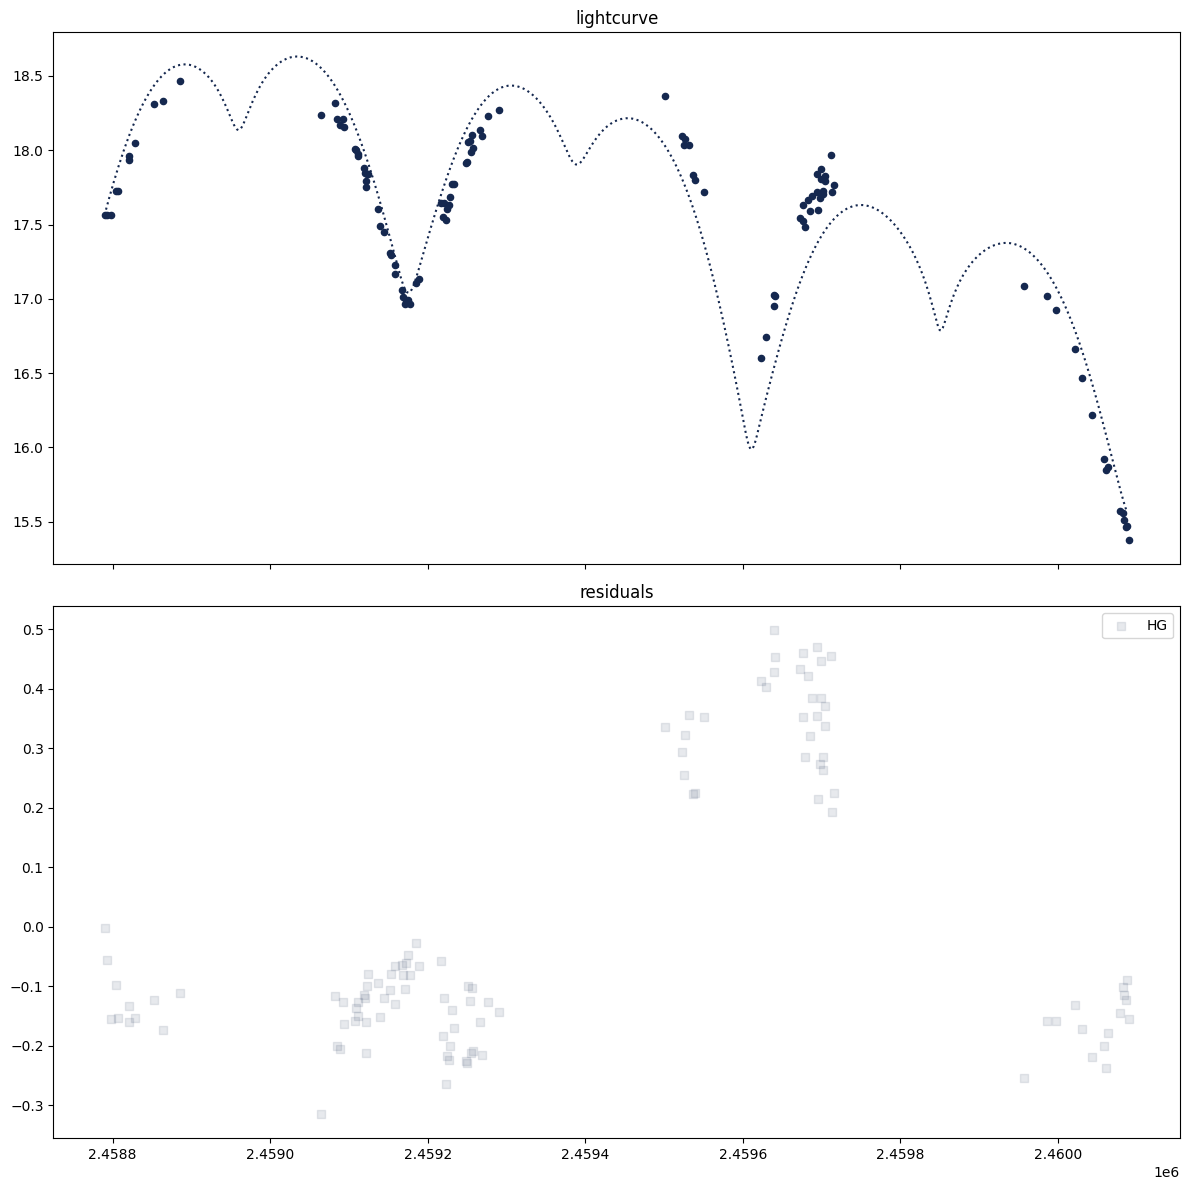

In [86]:
plot_lightcurve(hg)

1


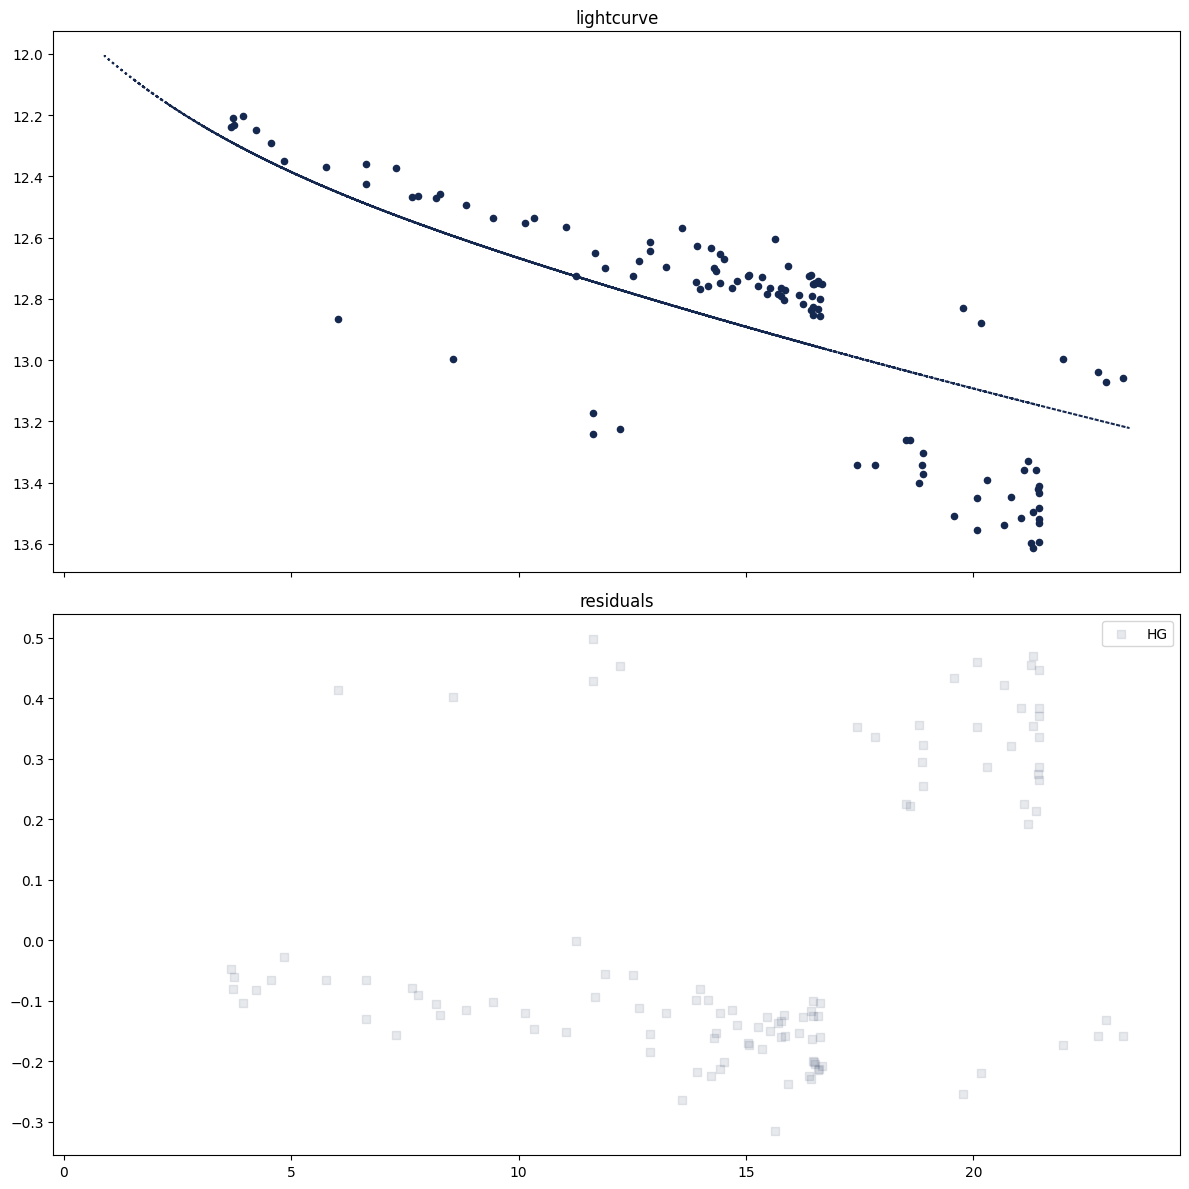

In [87]:
plot_phase(hg)

2


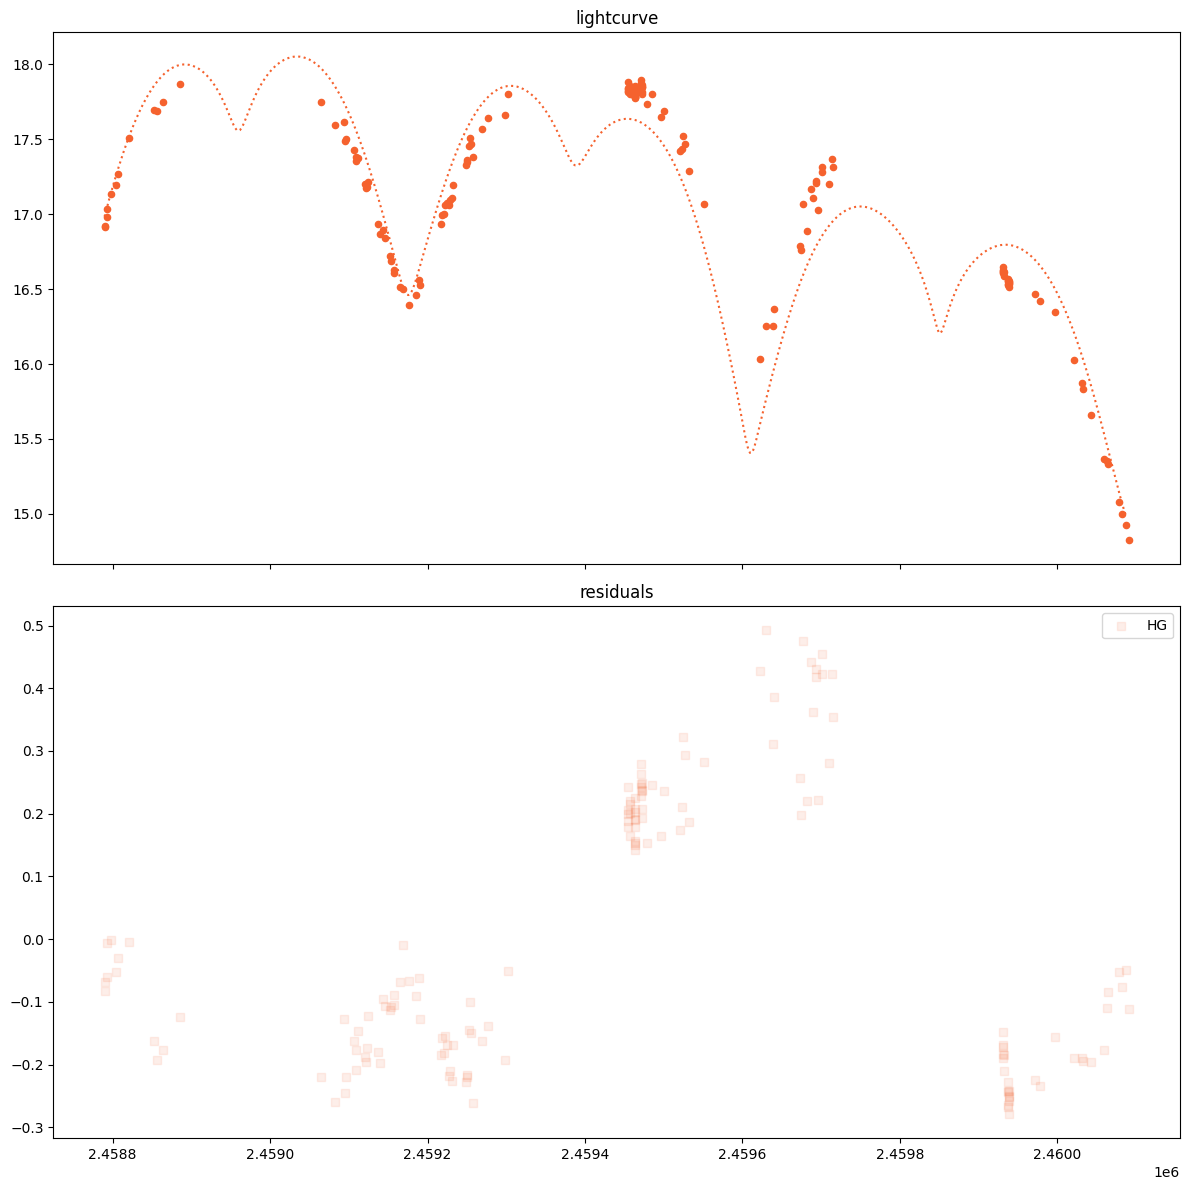

In [88]:
hg.reset_filter('r')
plot_lightcurve(hg)

In [89]:
hg1g2 = HG1G2('g', '1465')

1


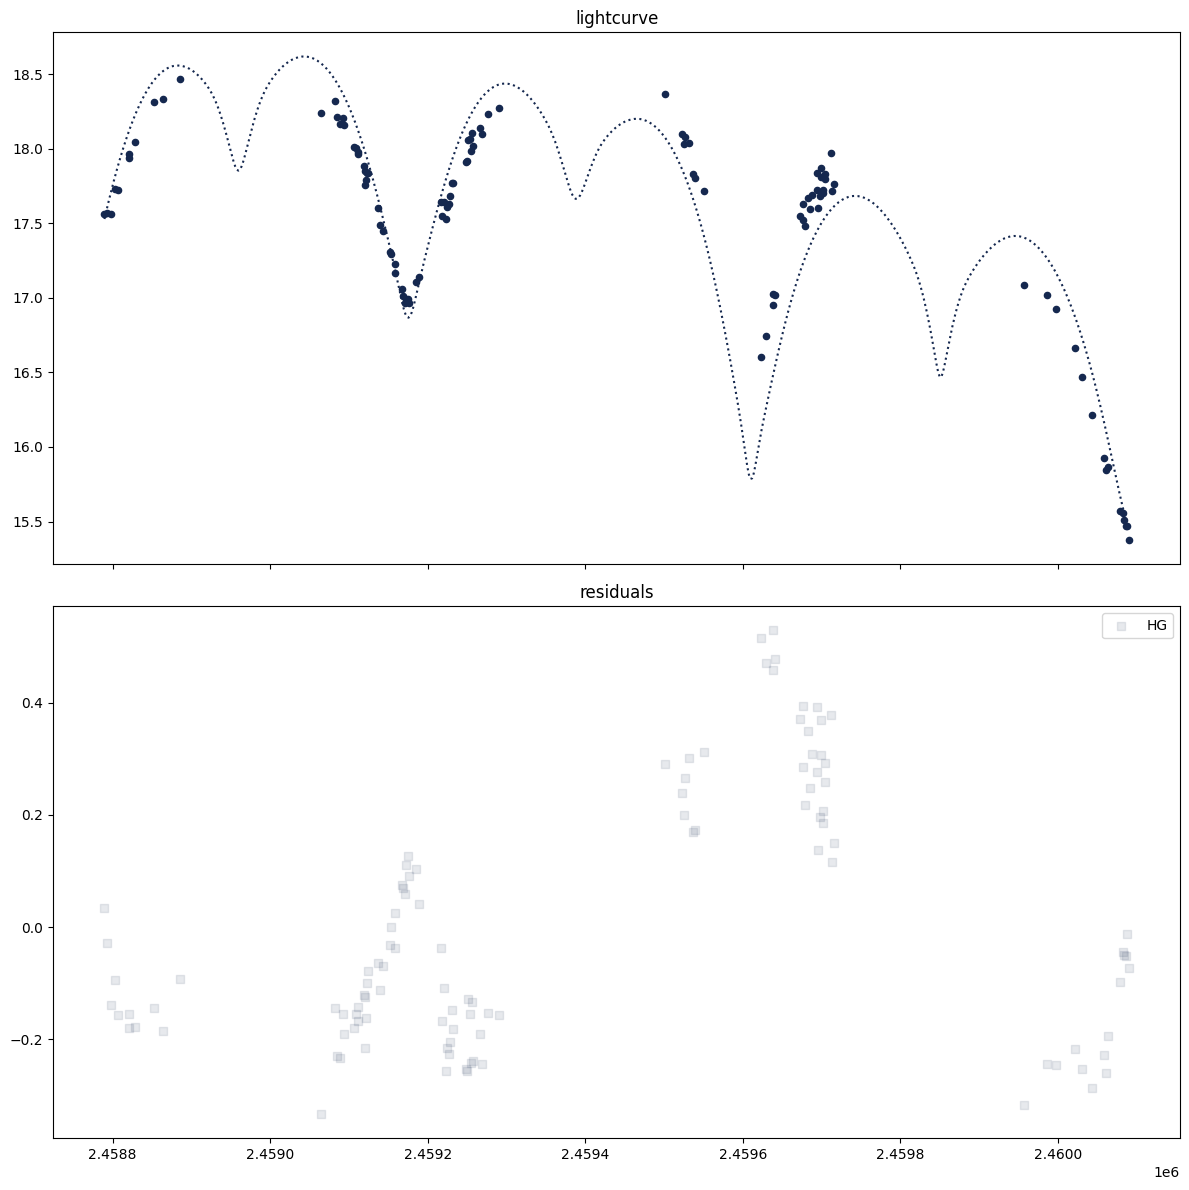

In [90]:
plot_lightcurve(hg1g2)

1


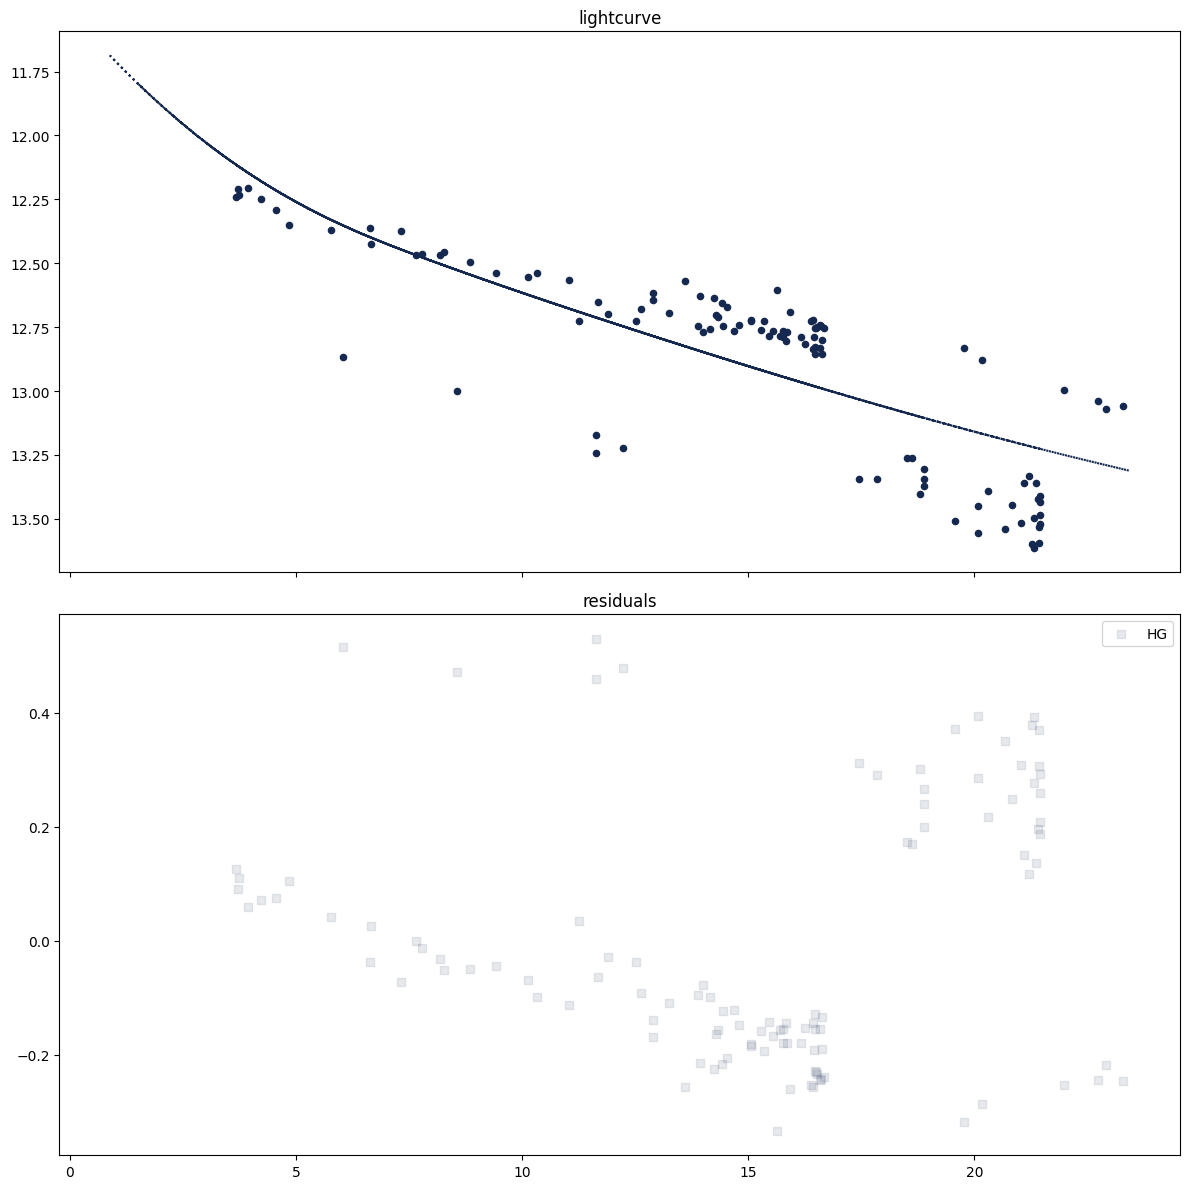

In [91]:
plot_phase(hg1g2)

2


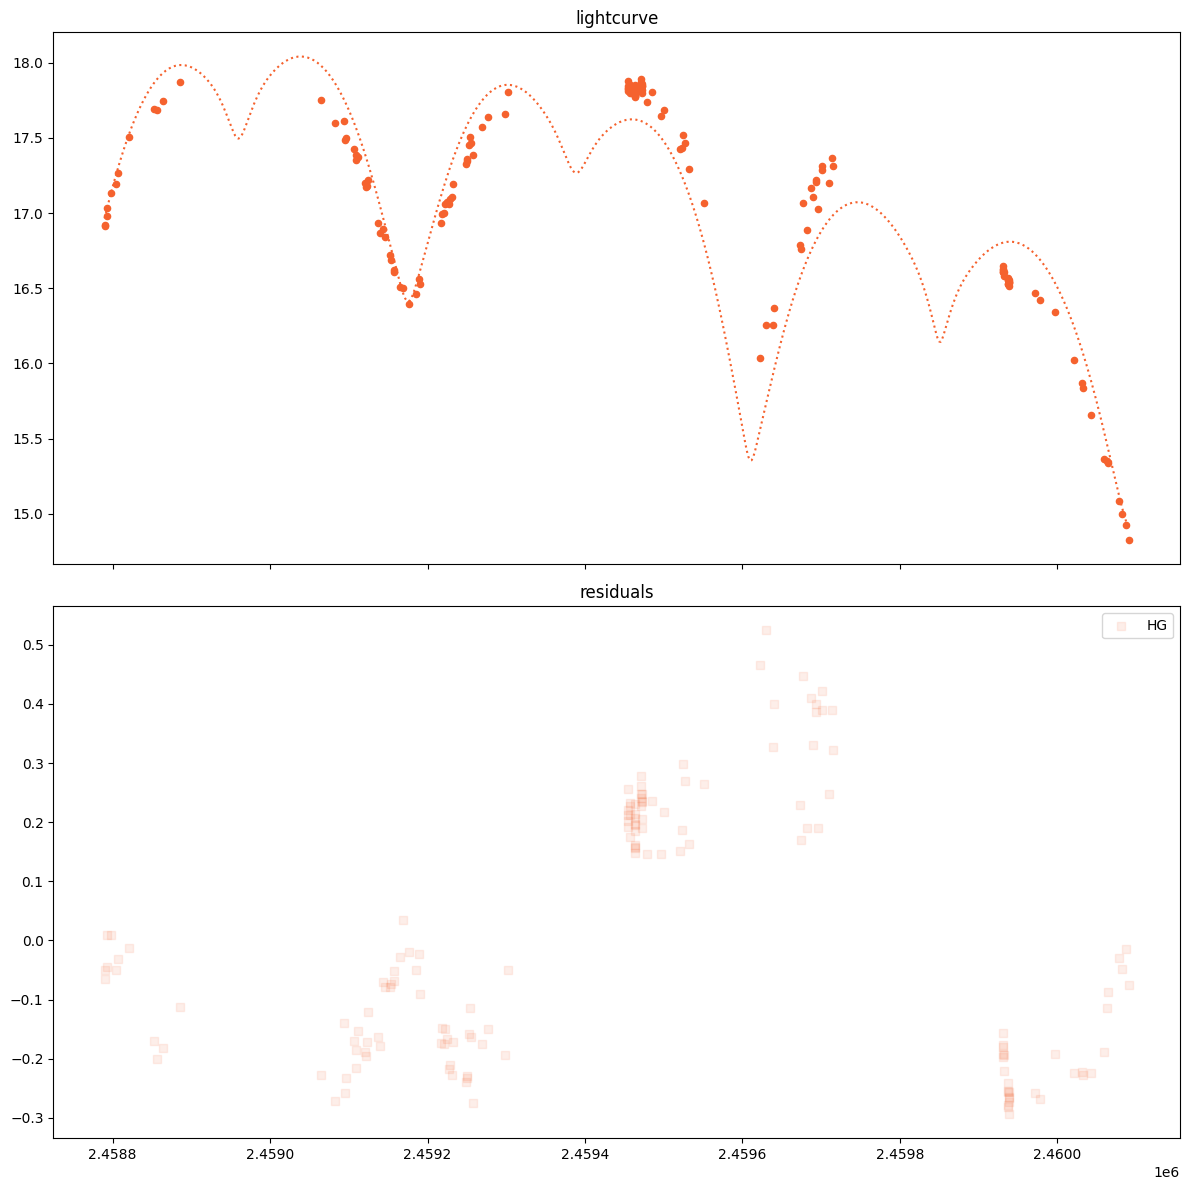

In [92]:
hg1g2.reset_filter('r')
plot_lightcurve(hg1g2)

2


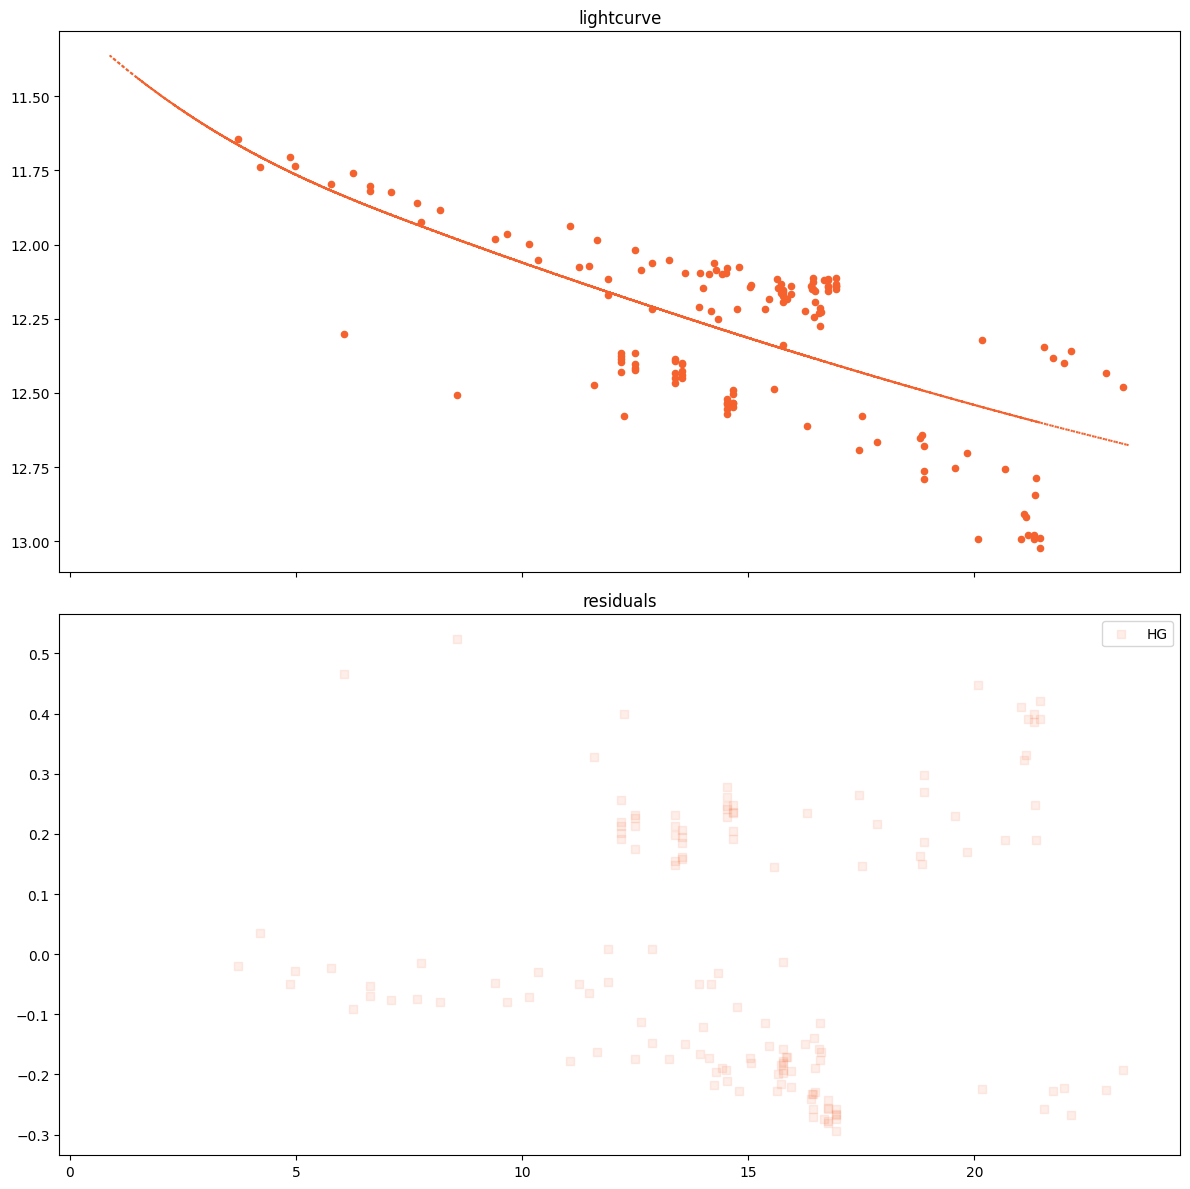

In [93]:
plot_phase(hg1g2)

In [94]:
shg1g2 = sHG1G2('g', '1465')

1


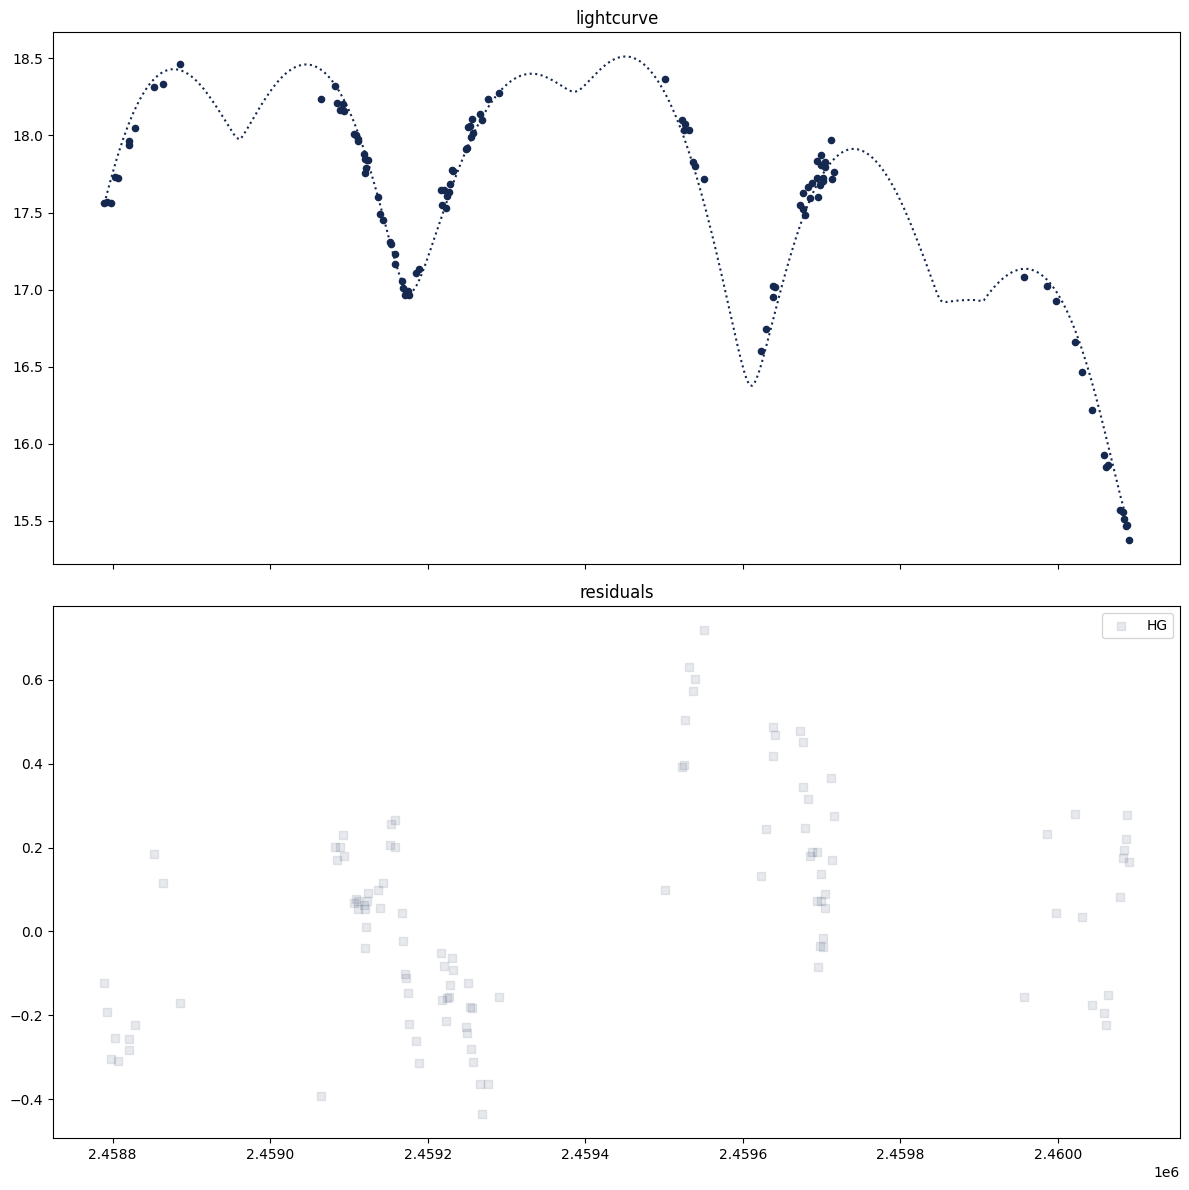

In [95]:
plot_lightcurve(shg1g2)

1


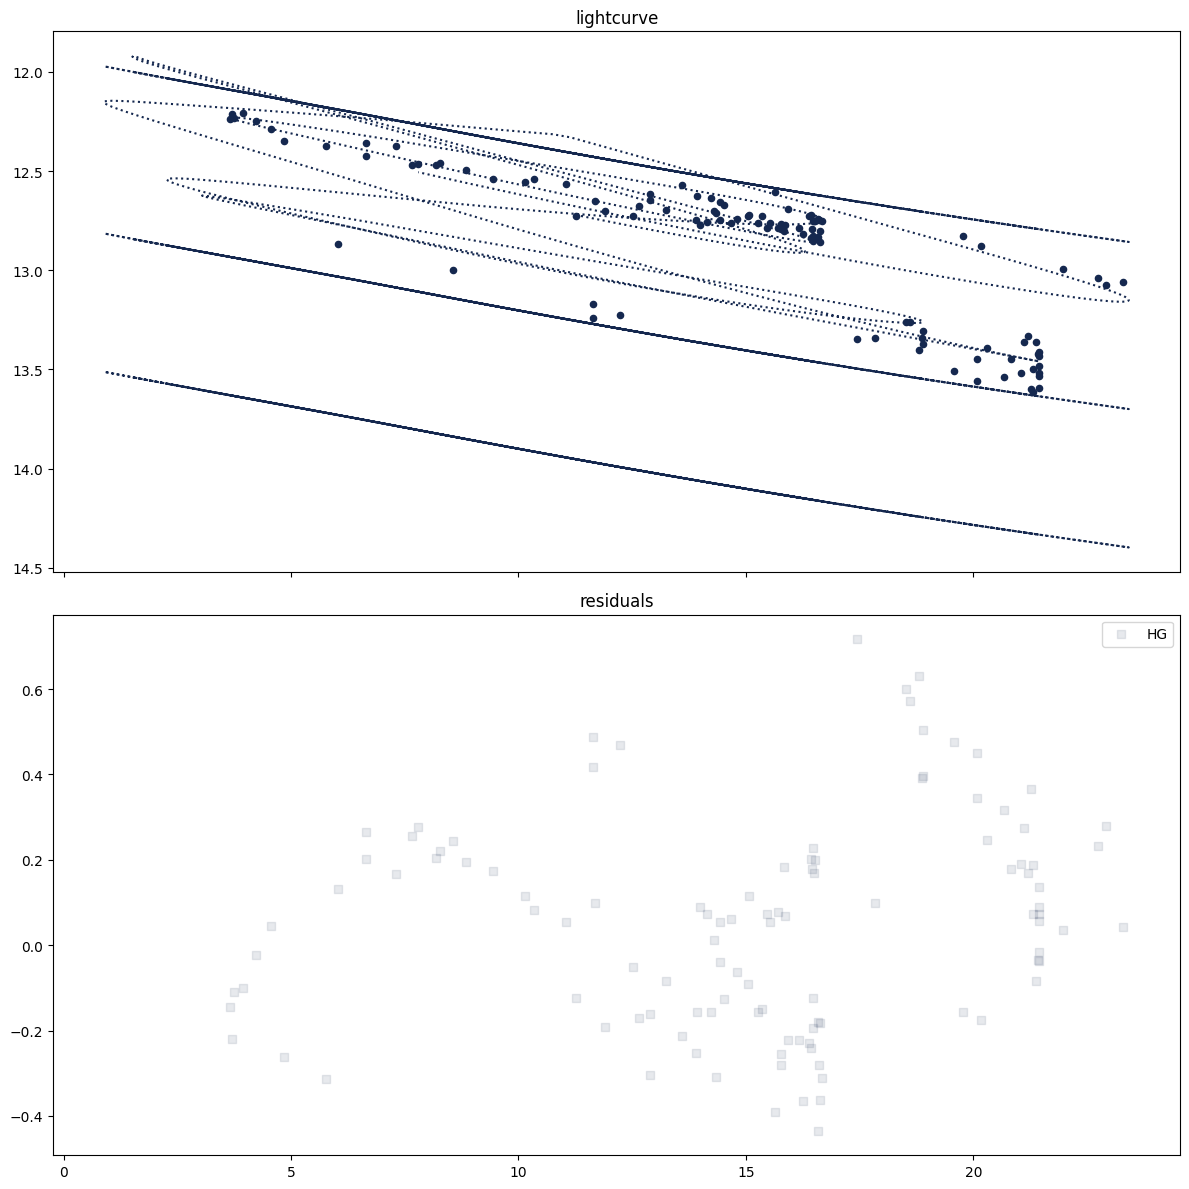

In [98]:
plot_phase(shg1g2)

2


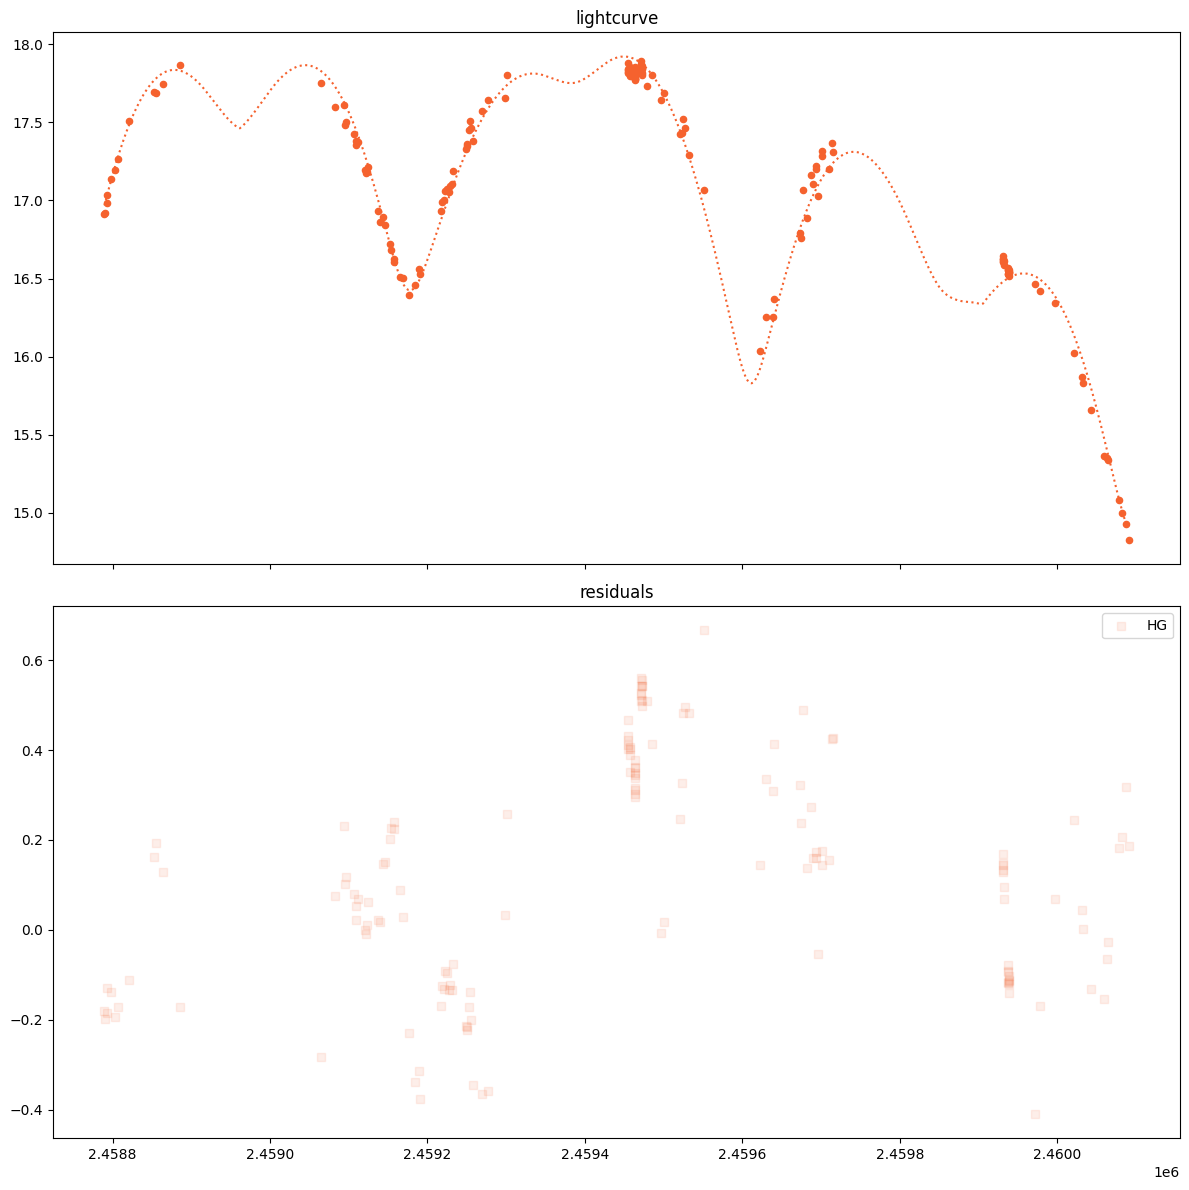

In [ ]:
shg1g2.reset_filter('r')
plot_lightcurve(shg1g2)

2


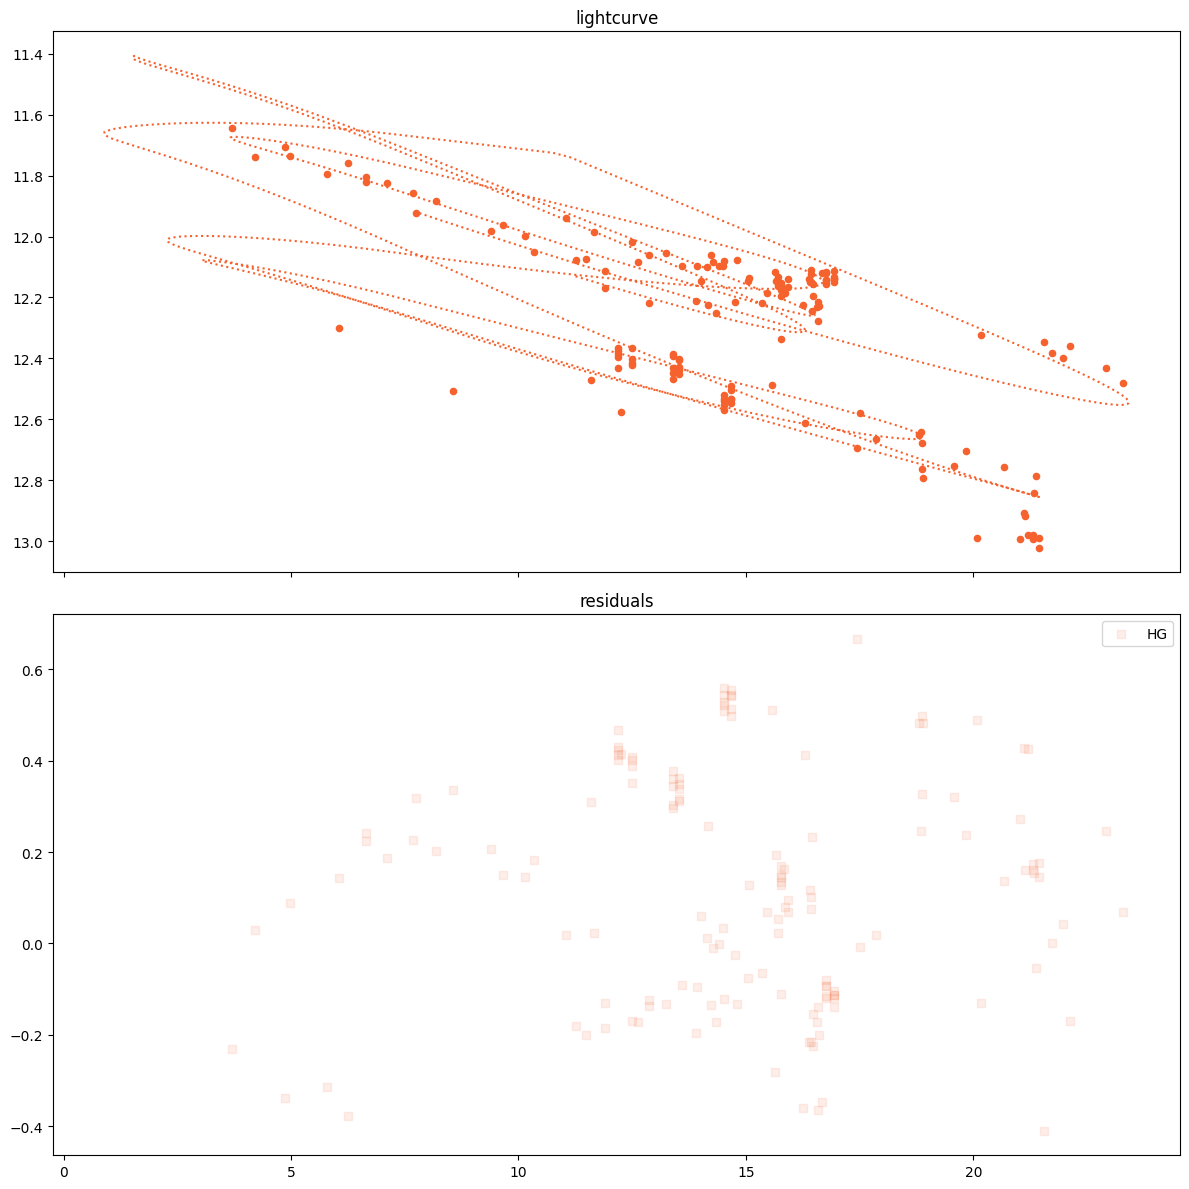

In [ ]:
plot_phase(shg1g2)

HG       : 11.88  0.00
HG1G2    : 11.37  0.40  0.00
HG21G1  g: 11.84  0.83  0.11   131.7  57.5   0.33    0.086
HG21G1  r: 11.42  1.00  0.13   131.7  57.5   0.33    0.086


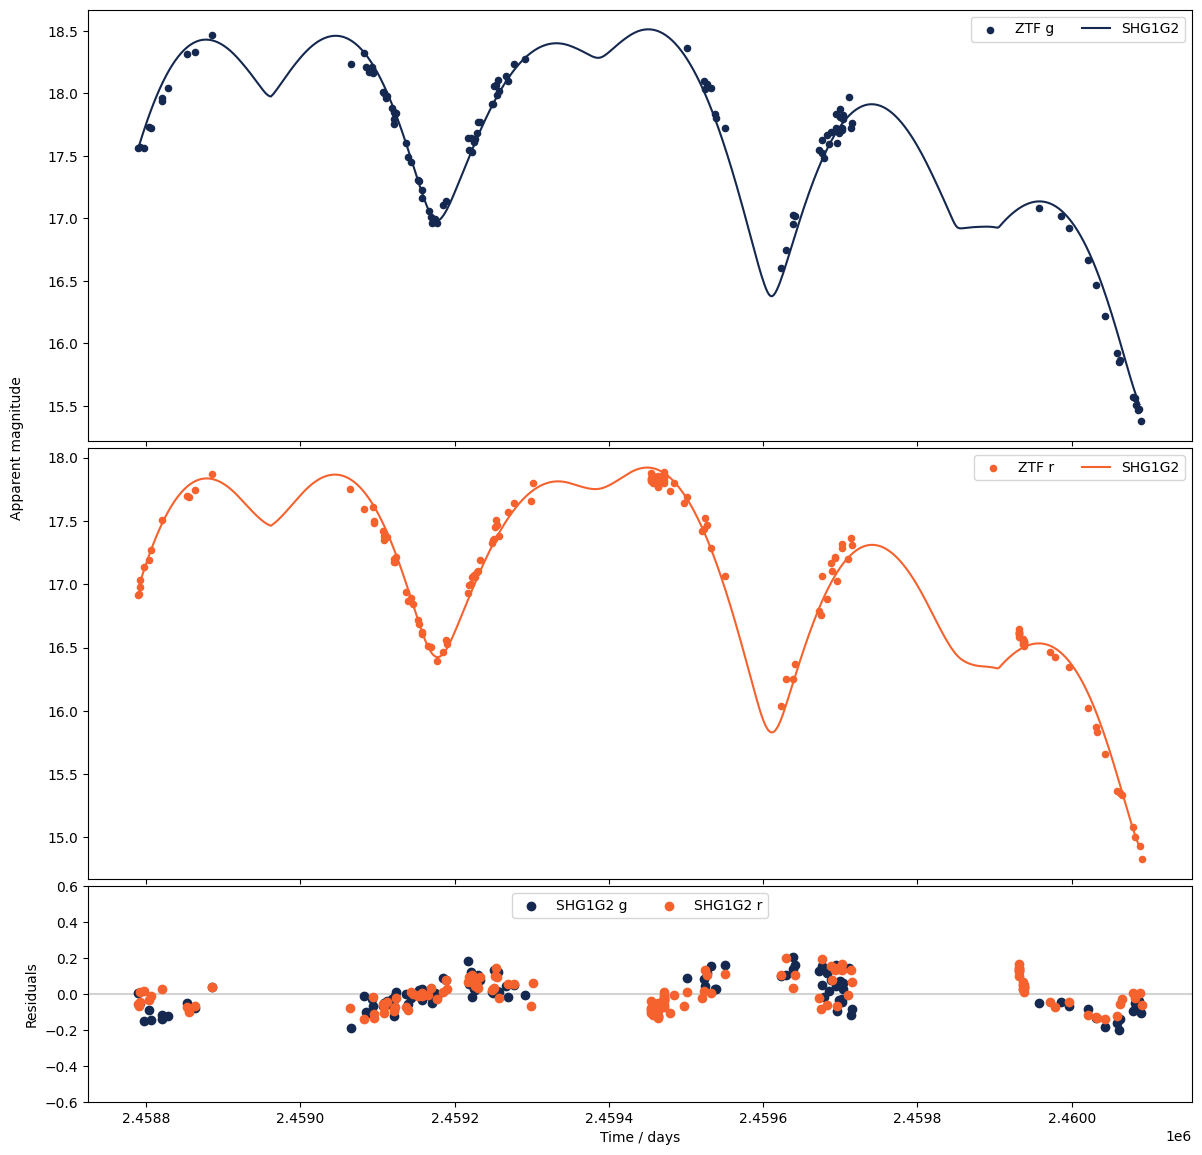

In [172]:
# Mag vs Time
fig, ax = plt.subplots(3, 1, figsize=(12,12), #fs.figsize(1), 
                       sharex=True, 
                       gridspec_kw={
                           'top':0.995, 
                           'left':0.075,
                           'right':0.995,
                           'bottom':0.085,
                           'hspace':0.02, 
                           'height_ratios': [2,2,1]
                       })
# ZTF Colors and Colors
colors = ['#15284F', '#F5622E']

show_HG = False
show_HG1G2 = False
show_HG1G2sp = False
show_sHG1G2 = True
# cond = ztf['i:fid']==fi+1
res_HG = False
res_HG1G2 = False
res_HG1G2sp = False
res_sHG1G2 = True

for fi, filt in enumerate(['g','r']):

    # --------------------------------------------------------------------------------
    # Plot ZTF observations
    cond = ztf['i:fid']==fi+1
    if filt=='g':
        color_corr = V_minus_g
    else:
        color_corr = V_minus_r
    
    ax[fi].scatter( ztf.loc[cond,'Date'], ztf.loc[cond,'i:magpsf'],
                    s=20, marker='o', 
                    color=colors[fi], 
                    label=f'ZTF {filt}' )
    
    # --------------------------------------------------------------------------------
    # HG model
    # Get Parameters
    H = data.loc[data.ssnamenr==target, 'HG_H_{}'.format(filt)].values[0]
    G = data.loc[data.ssnamenr==target, 'HG_G_{}'.format(filt)].values[0]
    if fi==0: print(f'HG       : {H:5.2f}  {G:4.2f}')
    
    # Linear Plot 
    if show_HG:
        pred_mag = finkus.func_hg(np.radians(eph['Phase']), H, G) \
                 + dist_reduction( eph['Dobs'], eph['Dhelio'] )
        ax[fi].plot( eph['Date'], pred_mag, color=colors[fi], linestyle='dotted', label=f'HG' )

        # if filt=='r':
        #     pred_mag = finkus.func_hg(np.radians(eph['Phase']), H, G) \
        #              + dist_reduction( eph['Dobs'], eph['Dhelio'] ) \
        #              - V_minus_r_fink
        #     ax[fi].plot( eph['Date'], pred_mag, color=colors[fi], linestyle='dotted', label=f'V-r=0.13' )

            
            
    # Plot residuals
    if res_HG:
        phase = ztf['Phase']
        pred_mag = finkus.func_hg(np.radians(phase), H, G)
        ax[2].scatter( ztf.loc[:,'Date'],
                   ztf.loc[:,'i:magpsf'] \
                    - dist_reduction( ztf.loc[:,'Dobs'], ztf.loc[:,'Dhelio'] ) \
                    - pred_mag, 
               color=colors[fi], alpha=0.1, marker='s', label=f'HG' )
        
    # --------------------------------------------------------------------------------
    # HG1G2 model
    # Get Parameters
    H = data.loc[data.ssnamenr==target, 'HG1G2_H_{}'.format(filt)].values[0]
    G1 = data.loc[data.ssnamenr==target, 'HG1G2_G1_{}'.format(filt)].values[0]
    G2 = data.loc[data.ssnamenr==target, 'HG1G2_G2_{}'.format(filt)].values[0]
    if fi==0: print(f'HG1G2    : {H:5.2f}  {G1:4.2f}  {G2:4.2f}')
    
    # Linear Plot 
    if show_HG1G2:
        pred_mag = finkus.func_hg1g2(np.radians(eph['Phase']), H, G1, G2) \
                 + dist_reduction( eph['Dobs'], eph['Dhelio'] )
        ax[fi].plot( eph['Date'], pred_mag, color=colors[fi], linestyle='dashed', label=f'HG1G2' )
    
    # Plot Residuals
    if res_HG1G2:
        pred_mag = finkus.func_hg1g2(np.radians(ztf.loc[cond,'Phase']), H, G1, G2)
        ax[2].scatter( ztf.loc[cond,'Date'],
                   ztf.loc[cond,'i:magpsf'] \
                    - dist_reduction( ztf.loc[cond,'Dobs'], ztf.loc[cond,'Dhelio'] ) \
                    - pred_mag, 
               color=colors[fi], alpha=0.1, marker='s', label=f'HG1G2 {filt}' )

    # --------------------------------------------------------------------------------
    # HG1G2spin model
    # Get Parameters
    # H = data.loc[data.ssnamenr==target, 'HG1G2sp_H'].values[0]
    # G1 = data.loc[data.ssnamenr==target, 'HG1G2sp_G1'].values[0]
    # G2 = data.loc[data.ssnamenr==target, 'HG1G2sp_G2'].values[0]
    # ra0 = data.loc[data.ssnamenr==target, 'HG1G2sp_RA0'].values[0]
    # dec0 = data.loc[data.ssnamenr==target, 'HG1G2sp_DEC0'].values[0]
    # R = data.loc[data.ssnamenr==target, 'sHG1G2_R'].values[0]
    # if fi==0: print(f'HG1G2spin: {H:5.2f}  {G1:4.2f}  {G2:4.2f}')

    # # Plot 
    # if show_HG1G2sp:
    #     radec = SkyCoord( eph.RA, eph.DEC, unit=(u.hourangle, u.deg) )
    #     pha = np.transpose([[i, j, k] for i, j, k in
    #                         zip(np.radians(eph.Phase),
    #                             np.radians(radec.ra.deg),
    #                             np.radians(radec.dec.deg))])
    #     pred_mag = finkus.func_hg1g2_with_spin(pha, H, G1, G2, R, np.radians(ra0), np.radians(dec0)) \
    #              + dist_reduction( eph['Dobs'], eph['Dhelio'] ) \
    #              - color_corr
    #     ax[fi].plot( eph['Date'], pred_mag, color=colors[fi], linestyle='dashdot', label=f'HG1G2 spin' )

    # # Plot residuals
    # if res_HG1G2sp:
    #     pha = np.transpose([[i, j, k] for i, j, k in
    #                         zip(np.radians(ztf.loc[cond,'Phase']),
    #                             np.radians(ztf.loc[cond,'RA']),
    #                             np.radians(ztf.loc[cond,'Dec']))])
    #     pred_mag = finkus.func_hg1g2_with_spin(pha, H, G1, G2, R, np.radians(ra0), np.radians(dec0)) - color_corr
    #     ax[2].scatter( ztf.loc[cond,'Date'], 
    #                ztf.loc[cond,'i:magpsf'] \
    #                 - dist_reduction( ztf.loc[cond,'Dobs'], ztf.loc[cond,'Dhelio'] )\
    #                 - pred_mag, 
    #            color=colors[fi], alpha=0.1, marker='s', label=f'HG1G2sp' )  
        
        
    # --------------------------------------------------------------------------------
    # Hybrid model
    # Get Parameters
    H = data.loc[data.ssnamenr==target, f'sHG1G2_H_{filt}'].values[0]
    G1 = data.loc[data.ssnamenr==target, f'sHG1G2_G1_{filt}'].values[0]
    G2 = data.loc[data.ssnamenr==target, f'sHG1G2_G2_{filt}'].values[0]
    ra0 = data.loc[data.ssnamenr==target, 'sHG1G2_RA0'].values[0]
    dec0 = data.loc[data.ssnamenr==target, 'sHG1G2_DEC0'].values[0]
    R = data.loc[data.ssnamenr==target, 'sHG1G2_R'].values[0]
    rms = data.loc[data.ssnamenr==target, 'sHG1G2_rms'].values[0]
    print(f'HG21G1  {filt}: {H:5.2f}  {G1:4.2f}  {G2:4.2f}   {ra0:4.1f}  {dec0:4.1f}   {R:4.2f}    {rms:.3f}')

    # Plot
    if show_sHG1G2:
        radec = SkyCoord( eph.RA, eph.DEC, unit=(u.hourangle, u.deg) )
        pha = np.transpose([[i, j, k] for i, j, k in
                            zip(np.radians(eph.Phase),
                                np.radians(radec.ra.deg),
                                np.radians(radec.dec.deg))])
        pred_mag = finkus.func_hg1g2_with_spin(pha, H, G1, G2, R, np.radians(ra0), np.radians(dec0))  \
                 + dist_reduction( eph['Dobs'], eph['Dhelio'] ) 
        ax[fi].plot( eph['Date'], pred_mag, color=colors[fi], label=f'SHG1G2' )

#         x = eph['Date']
#         y = pred_mag

#         points = np.array([x, y]).T.reshape(-1, 1, 2)
#         segments = np.concatenate([points[:-1], points[1:]], axis=1)


#         norm = plt.Normalize(x.min(), x.max())
#         lc = LineCollection(segments, cmap='Oranges', norm=norm, label=f'HG1G2 Hybrid')

#         lc.set_array(x)
#         lc.set_linewidth(2)
#         line = ax[fi].add_collection(lc)
        # ax[fi].plot( eph['Date'], pred_mag, c=col_date, cmap='Oranges', label=f'HG1G2 Hybrid' )

    # Plot Residuals
    if res_sHG1G2:
        pha = np.transpose([[i, j, k] for i, j, k in
                            zip(np.radians(ztf.loc[cond,'Phase']),
                                np.radians(ztf.loc[cond,'RA']),
                                np.radians(ztf.loc[cond,'Dec']))])
        pred_mag = finkus.func_hg1g2_with_spin(pha, H, G1, G2, R, np.radians(ra0), np.radians(dec0)) 
        ax[2].scatter( ztf.loc[cond,'Date'], 
                       ztf.loc[cond,'i:magpsf'] \
                        - dist_reduction( ztf.loc[cond,'Dobs'], ztf.loc[cond,'Dhelio'] ) \
                        - pred_mag, 
                   color=colors[fi], label=f'SHG1G2 {filt}' )
    
    
    # ax[fi].set_ylabel(f'Apparent magnitude in {filt}')
    ax[fi].legend(ncol=2)#loc='upper right')
    

# Residuals
ax[2].axhline(0, color='lightgray', zorder=-100)
ax[2].set_ylim(-0.6,0.6)
ax[2].legend(ncol=4, loc='upper center')
ax[2].set_ylabel('Residuals')
    
fig.text(0.01, 0.63, 'Apparent magnitude',  va='center', rotation='vertical')

    
# Axes
ax[2].set_xlabel('Time / days')

# fig.savefig(f'{data_fink}/gfx_obs/{target}-time.png', facecolor='white')
# fig.savefig(f'{data_fink}/gfx_obs/{target}-time.pgf', facecolor='white')
plt.show()

HG       : 11.88  0.00
HG1G2    : 11.37  0.40  0.00
HG21G1  g: 11.84  0.83  0.11   131.7  57.5   0.33
HG21G1  r: 11.42  1.00  0.13   131.7  57.5   0.33


(0.0, 24.542224524632452)

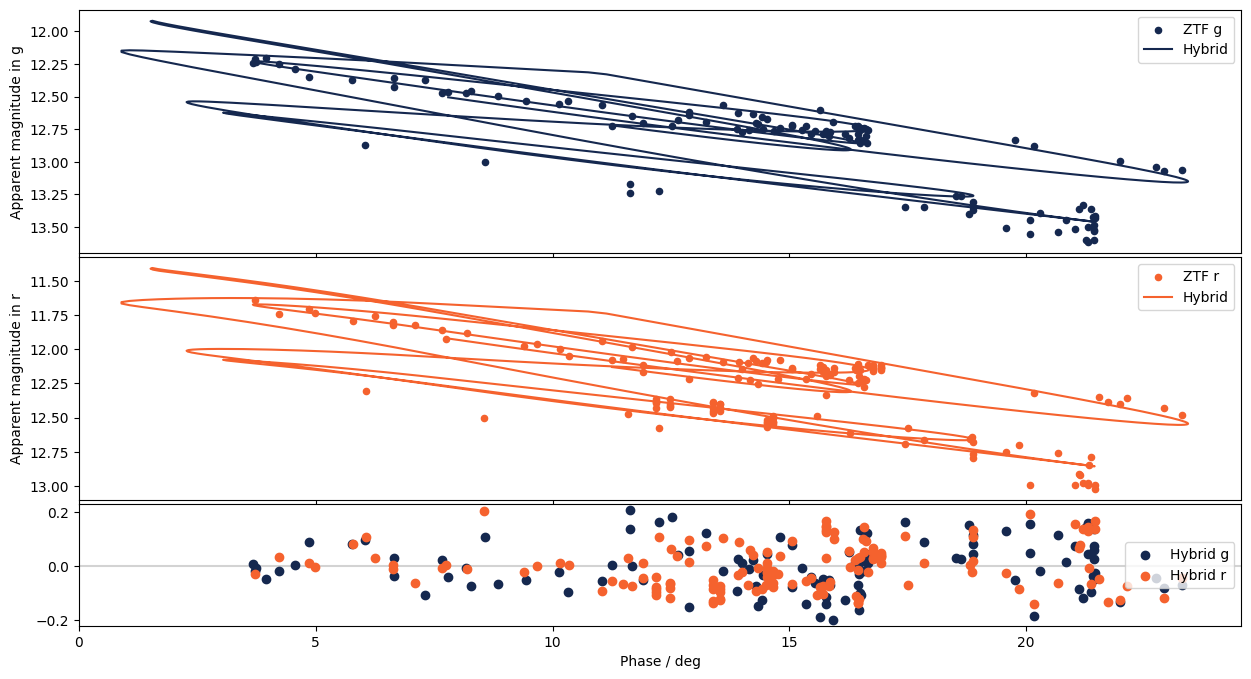

In [260]:
# Mag vs Phase
fig, ax = plt.subplots(3, 1, figsize=(15,8), 
                       sharex=True, 
                       gridspec_kw={
                           'hspace':0.02, 
                           'height_ratios': [2,2,1]
                       })

# ZTF Colors and Colors
colors = ['#15284F', '#F5622E']
       

show_HG = False
show_HG1G2 = False
show_HG1G2sp = False
show_sHG1G2 = True

res_HG = False
res_HG1G2 = False
res_HG1G2sp = False
res_sHG1G2 = True


for fi, filt in enumerate(['g','r']):

    # --------------------------------------------------------------------------------
    # Plot ZTF observations
    cond = ztf['i:fid']==fi+1
    if filt=='g':
        color_corr = V_minus_g
    else:
        color_corr = V_minus_r
    
    ax[fi].scatter( ztf.loc[cond,'Phase'],
                    ztf.loc[cond,'i:magpsf'] - dist_reduction( ztf.loc[cond,'Dobs'], ztf.loc[cond,'Dhelio'] ) ,
                    s=20, marker='o', 
                    color=colors[fi], 
                    label=f'ZTF {filt}' )
    
    # --------------------------------------------------------------------------------
    # HG model
    # Get Parameters
    H = data.loc[data.ssnamenr==target, 'HG_H_{}'.format(filt)].values[0]
    G = data.loc[data.ssnamenr==target, 'HG_G_{}'.format(filt)].values[0]
    if fi==0: print(f'HG       : {H:5.2f}  {G:4.2f}')
    
    # Linear Plot 
    if show_HG:
        pred_mag = finkus.func_hg(np.radians(eph['Phase']), H, G)
        ax[fi].plot( eph['Phase'], pred_mag, color=colors[fi], linestyle='dotted', label=f'HG' )
    
    # Plot residuals
    if res_HG:
        phase = ztf['Phase']
        pred_mag = finkus.func_hg(np.radians(phase), H, G)
        ax[2].scatter( ztf.loc[:,'Phase'],
                   ztf.loc[:,'i:magpsf'] \
                    - dist_reduction( ztf.loc[:,'Dobs'], ztf.loc[:,'Dhelio'] ) \
                    - pred_mag, 
               color=colors[fi], alpha=0.1, marker='s', label=f'HG' )
    
    
    
    # --------------------------------------------------------------------------------
    # HG1G2 model
    # Get Parameters
    H = data.loc[data.ssnamenr==target, 'HG1G2_H_{}'.format(filt)].values[0]
    G1 = data.loc[data.ssnamenr==target, 'HG1G2_G1_{}'.format(filt)].values[0]
    G2 = data.loc[data.ssnamenr==target, 'HG1G2_G2_{}'.format(filt)].values[0]
    if fi==0: print(f'HG1G2    : {H:5.2f}  {G1:4.2f}  {G2:4.2f}')
    
    # Plot 
    if show_HG1G2:
        pred_mag = finkus.func_hg1g2(np.radians(eph['Phase']), H, G1, G2) - color_corr
        ax[fi].plot( eph['Phase'], pred_mag, color=colors[fi], linestyle='dashed', label=f'HG1G2' )
    
    # Plot Residuals
    if res_HG1G2:
        pred_mag = finkus.func_hg1g2(np.radians(ztf.loc[cond,'Phase']), H, G1, G2) - color_corr
        ax[2].scatter( ztf.loc[cond,'Phase'],
                   ztf.loc[cond,'i:magpsf'] \
                    - dist_reduction( ztf.loc[cond,'Dobs'], ztf.loc[cond,'Dhelio'] ) \
                    - pred_mag, 
               color=colors[fi], alpha=0.1, marker='s', label=f'HG1G2 {filt}' )

    
    # --------------------------------------------------------------------------------
    # HG1G2spin model
    # Get Parameters
    # H = data.loc[data.ssnamenr==target, 'HG1G2sp_H'].values[0]
    # G1 = data.loc[data.ssnamenr==target, 'HG1G2sp_G1'].values[0]
    # G2 = data.loc[data.ssnamenr==target, 'HG1G2sp_G2'].values[0]
    # ra0 = data.loc[data.ssnamenr==target, 'HG1G2sp_RA0'].values[0]
    # dec0 = data.loc[data.ssnamenr==target, 'HG1G2sp_DEC0'].values[0]
    # R = data.loc[data.ssnamenr==target, 'sHG1G2_R'].values[0]
    # if fi==0: print(f'HG1G2spin: {H:5.2f}  {G1:4.2f}  {G2:4.2f}')

    # # Linear Plot 
    # if show_HG1G2sp:
    #     radec = SkyCoord( eph.RA, eph.DEC, unit=(u.hourangle, u.deg) )
    #     pha = np.transpose([[i, j, k] for i, j, k in
    #                         zip(np.radians(eph.Phase),
    #                             np.radians(radec.ra.deg),
    #                             np.radians(radec.dec.deg))])
    #     pred_mag = finkus.func_hg1g2_with_spin(pha, H, G1, G2, R, np.radians(ra0), np.radians(dec0)) - color_corr
    #     ax[fi].plot( eph['Phase'], pred_mag, color=colors[fi], linestyle='dashdot', label=f'HG1G2 spin' )
    
    # # Plot residuals
    # if res_HG1G2sp:
    #     pha = np.transpose([[i, j, k] for i, j, k in
    #                         zip(np.radians(ztf.loc[cond,'Phase']),
    #                             np.radians(ztf.loc[cond,'RA']),
    #                             np.radians(ztf.loc[cond,'Dec']))])
    #     pred_mag = finkus.func_hg1g2_with_spin(pha, H, G1, G2, R, np.radians(ra0), np.radians(dec0)) - color_corr
    #     ax[2].scatter( ztf.loc[cond,'Phase'],
    #                ztf.loc[cond,'i:magpsf'] \
    #                 - dist_reduction( ztf.loc[cond,'Dobs'], ztf.loc[cond,'Dhelio'] ) \
    #                 - pred_mag, 
    #            color=colors[fi], alpha=0.1, marker='s', label=f'HG1G2sp' )
    
    
    # --------------------------------------------------------------------------------
    # Hybrid model
    # Get Parameters
    H = data.loc[data.ssnamenr==target, f'sHG1G2_H_{filt}'].values[0]
    G1 = data.loc[data.ssnamenr==target, f'sHG1G2_G1_{filt}'].values[0]
    G2 = data.loc[data.ssnamenr==target, f'sHG1G2_G2_{filt}'].values[0]
    ra0 = data.loc[data.ssnamenr==target, 'sHG1G2_RA0'].values[0]
    dec0 = data.loc[data.ssnamenr==target, 'sHG1G2_DEC0'].values[0]
    R = data.loc[data.ssnamenr==target, 'sHG1G2_R'].values[0]
    print(f'HG21G1  {filt}: {H:5.2f}  {G1:4.2f}  {G2:4.2f}   {ra0:4.1f}  {dec0:4.1f}   {R:4.2f}')

    # Nice linear Plot
    if show_sHG1G2:
        radec = SkyCoord( eph.RA, eph.DEC, unit=(u.hourangle, u.deg) )
        pha = np.transpose([[i, j, k] for i, j, k in
                            zip(np.radians(eph.Phase),
                                np.radians(radec.ra.deg),
                                np.radians(radec.dec.deg))])
        pred_mag = finkus.func_hg1g2_with_spin(pha, H, G1, G2, R, np.radians(ra0), np.radians(dec0)) 
        ax[fi].plot( eph['Phase'], pred_mag, color=colors[fi], label=f'Hybrid' )

        
#         c = eph['Date']
#         x = eph['Phase']
#         y = pred_mag

#         points = np.array([x, y]).T.reshape(-1, 1, 2)
#         segments = np.concatenate([points[:-1], points[1:]], axis=1)


#         norm = plt.Normalize(c.min(), c.max())
#         lc = LineCollection(segments, cmap='plasma', norm=norm, label=f'HG1G2 Hybrid')

#         lc.set_array(c)
#         lc.set_linewidth(2)
#         line = ax[fi].add_collection(lc)
        
        
    
    # Plot Residuals
    if res_sHG1G2:
        pha = np.transpose([[i, j, k] for i, j, k in
                            zip(np.radians(ztf.loc[cond,'Phase']),
                                np.radians(ztf.loc[cond,'RA']),
                                np.radians(ztf.loc[cond,'Dec']))])
        pred_mag = finkus.func_hg1g2_with_spin(pha, H, G1, G2, R, np.radians(ra0), np.radians(dec0)) 
        ax[2].scatter( ztf.loc[cond,'Phase'],
                       ztf.loc[cond,'i:magpsf'] \
                        - dist_reduction( ztf.loc[cond,'Dobs'], ztf.loc[cond,'Dhelio'] ) \
                        - pred_mag, 
                   color=colors[fi], label=f'Hybrid {filt}' )
    
    
    # Axes
    ax[fi].set_ylim( np.flip( ax[fi].get_ylim() ) )
    ax[fi].set_ylabel(f'Apparent magnitude in {filt}')
    ax[fi].legend(loc='upper right')
    

# Residuals
ax[2].axhline(0, color='lightgray', zorder=-100)
ax[2].legend(loc='center right')
    
    
# Axes
ax[2].set_xlabel('Phase / deg')
ax[2].set_xlim(0)

# fig.savefig(f'{data_fink}/gfx_obs/{target}-phase.png', facecolor='white')

In [ ]:

# Special Dedicace a Julien :-)

# How to find oppositions
p_conj = eph['Elong.'].isin( eph['Elong.'].values[argrelextrema(eph['Elong.'].values, np.greater)[0]] )
nb_oppo = len(eph[p_conj])

#
# Compute Lambda
coords = SkyCoord( eph.RA, eph.DEC, unit=(u.hourangle, u.deg) )

ra0 = data.loc[data.ssnamenr==target, 'sHG1G2_RA0'].values[0]
dec0 = data.loc[data.ssnamenr==target, 'sHG1G2_DEC0'].values[0]

ra = np.radians(coords.ra.deg)
dec = np.radians(coords.dec.deg)
cos_lambda = np.sin(dec)*np.sin(dec0) + np.cos(dec)*np.cos(dec0)*np.cos(ra-ra0)
eph['cosLambda'] = cos_lambda

# Graphically
fig, ax = plt.subplots()

# First part
cond = eph.Date < eph.loc[p_conj,'Date'].values[0]
ax.scatter( eph.loc[cond,'Date'], eph.loc[cond,'cosLambda'] )

# All middle part until last
for ko in range(1,nb_oppo):
    cond = (eph.Date > eph.loc[p_conj,'Date'].values[ko-1]) & (eph.Date < eph.loc[p_conj,'Date'].values[ko])
    ax.scatter( eph.loc[cond,'Date'], eph.loc[cond,'cosLambda'] )

# Last opposition
cond = eph.Date > eph.loc[p_conj,'Date'].values[-1]
ax.scatter( eph.loc[cond,'Date'], eph.loc[cond,'cosLambda'] )

for ko in range(nb_oppo):
    ax.axvline( eph.loc[p_conj,'Date'].values[ko] )
